# Brain tumor detector

## Nutshell
In this project I build a program that detects and localizes cancer from images of human brains, as explained on the course *Modern Artificial Intelligence*, lectured by Dr. Ryan Ahmed, Ph.D. MBA.

I will train two models which will
1.   classify the images either containing cancer tumor or not
2.   localizes the tumor within the brain


In [11]:
#HIDE
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
#HIDE
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [37]:
#HIDE
# @title Loading libraries and setting up drive
%%capture

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'

# Import the necessary packages
import io
import pandas as pd
import numpy as np
import os
import glob
import random
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, CSVLogger
from IPython.display import display
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import copy
from graphviz import Digraph
from IPython.display import Javascript, HTML, Image, display, SVG
import copy
from scipy.ndimage import rotate
import requests
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K

from pathlib import Path

from utilities import prediction, tversky, tversky_loss, focal_tversky
import plotly.io as pio
pio.renderers.default = "notebook_connected"

retrain_model = False  # ← Change to True when you want to retrain
rerun_example = False  # ← Change to True when you want to rerun the example
push_git = False # <- Change this to True when you wan to push the changes

image_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/docs/pics')

MRI_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI')
model_base = Path('/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models')

In [3]:
#HIDE
%%capture
%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'

In [3]:
#HIDE
import matplotlib as mpl

grey = "#e9ecef"
legend_bg = "#272b30"
mpl.rcParams.update({
    # text
    "text.color": grey,
    "axes.labelcolor": grey,
    "axes.titlecolor": grey,
    "xtick.color": grey,
    "ytick.color": grey,

    # axes / spines / grid
    "axes.edgecolor": grey,
    "grid.color": grey,

    # legend
    "legend.labelcolor": grey,
    "legend.facecolor": legend_bg,
    "legend.edgecolor": "none",

    # Transparent backgrounds everywhere
    "figure.facecolor": "none",
    "axes.facecolor": "none",
    "savefig.facecolor": "none",
    "savefig.transparent": True,
})


# Introduction to the Brain Tumor Detection

Deep learning has proven to be as good and even better than humans in detecting diseases from X-rays, MRI scans and CT scans. there is huge potential in using AI to speed up and improve the accuracy of diagnosis.
This project will use the labeled dataset from https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation which consists of 3929 Brain MRI scans and the tumor location.
The final pipeline has a two step process where
1. A **Resnet deep learning classifier model** will classify the input images into two groups: tumor detected and tumor not detected.
2. For the images, where tumor was detected, a second step is performed, where a **ResUNet segmentation model** detects the tumor location on the pixel level.


## Image segmentation

Image segmentation extracts information from images on the level of pixels. It is used for object recognition and localization in applications like medical imaging and self-driving cars. Image segmentation **produces a pixel-wise mask** of the image with deep learning approaches using common architectures such as CNN, FNNs and Deep Encoders-Decoders.

With Unet, the input and the output have the same size so the size of the images is preserved. In contrast to the CNN image classification, where the image is converted to a vector and the entire image is classified as a class label, the Unet performs classification on pixel level. Unet formulates a loss function for every pixel and then a softmax function is applied to every pixel. In other words, the segmentation problem is solved as a classification problem.

## Looking into the data

We have a csv file that contains the patient IDs, the locations of the images, their masks and indicator if there is a tumor in the image (1 - tumor, 0 - healthy). There are 1373 images with tumors and 2556 healthy brain images. Thus, the dataset is imbalanced.

In [4]:
#HIDE
# data containing path to Brain MRI and their corresponding mask

brain_df = pd.read_csv(MRI_base/"data_mask.csv")
brain_df.info()
brain_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [6]:
#HIDE
brain_df.mask_path[1] # Path to the brain MRI image

In [ ]:
#HIDE
brain_df.image_path[1] # Path to the segmentation mask

In [ ]:
#HIDE
brain_df['mask'].value_counts()

## Visualisation of the datasets

In [5]:
#HIDE
palette_hex = {"InputLayer": "#ffaa00",
    "ZeroPadding2D":"#e9854f",
    "Conv2D": "#8ECAE6",
    "BatchNormalization": "#219EBC",
    "Activation": "#023047",
    "ReLU": "#993461",
    "Add": "#126782",
    "MaxPooling2D": "#f09135",
    "AveragePooling2D": "#f09135",
    "Flatten": "#bd5665",
    "Dense": "#993461",
    "Dropout": "#692161"}
mask_counts = brain_df['mask'].value_counts()
colors = list(palette_hex.values())[5:] # Get a list of color values and slice for the number of bars

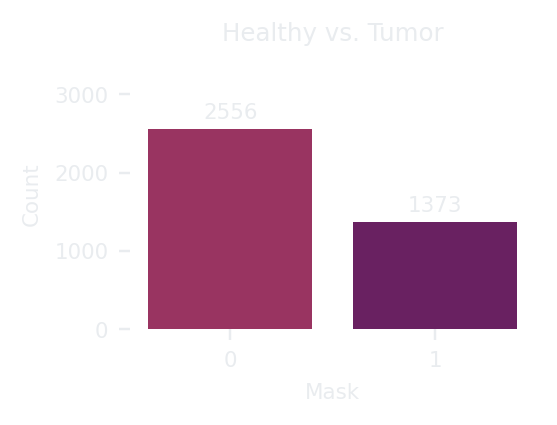

In [8]:
#HIDE
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display

counts = brain_df["mask"].value_counts().sort_index()

# smaller figure + slightly smaller fonts
fig, ax = plt.subplots(figsize=(2.4, 1.8))
fig.patch.set_alpha(0)
ax.set_facecolor("none")

bar_colors = ["#993461", "#692161"][:len(counts)]
bars = ax.bar(
    [str(x) for x in counts.index],
    counts.values,
    color=bar_colors,
    edgecolor="none",
    linewidth=0
)

ymax = counts.values.max() if len(counts) else 1
ax.set_ylim(0, ymax * 1.35)

ax.bar_label(bars, labels=[str(int(v)) for v in counts.values],
             padding=2, color="#e9ecef", fontsize=7)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("Healthy vs. Tumor", color="#e9ecef", fontsize=8)
ax.set_xlabel("Mask", color="#e9ecef", fontsize=7)
ax.set_ylabel("Count", color="#e9ecef", fontsize=7)
ax.tick_params(colors="#e9ecef", labelsize=7)

plt.tight_layout(pad=0.2)

os.makedirs("docs/pics", exist_ok=True)
out_path = "docs/pics/mask_counts_tiny.png"
fig.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.close(fig)

# display smaller in the notebook/html too
display(Image(filename=out_path, width=460))


Below is an example of an MRI image and the matching mask. This example has a small tumor. In images where no tumor is present, the mask will be completely black.

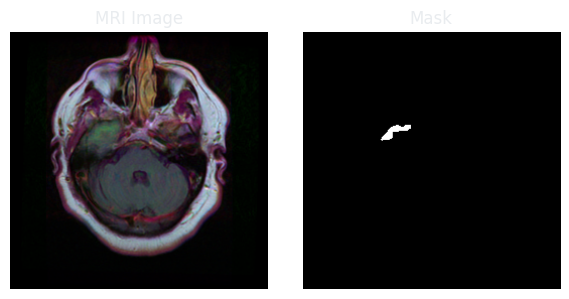

In [9]:
#HIDE

mask = brain_df.mask_path[623]

img = brain_df.image_path[623]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.patch.set_alpha(0)     # transparent figure bg
ax.set_facecolor("none")   # transparent axes bg

axes[0].imshow(cv2.imread(img))
axes[0].set_title("MRI Image", color="#e9ecef")
axes[0].axis("off")

axes[1].imshow(cv2.imread(mask), cmap="gray")
axes[1].set_title("Mask", color="#e9ecef")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Below are visualisations from 6 MRIs and their overlayed masks in rose color to get a sense of the data that I will be using in this project.

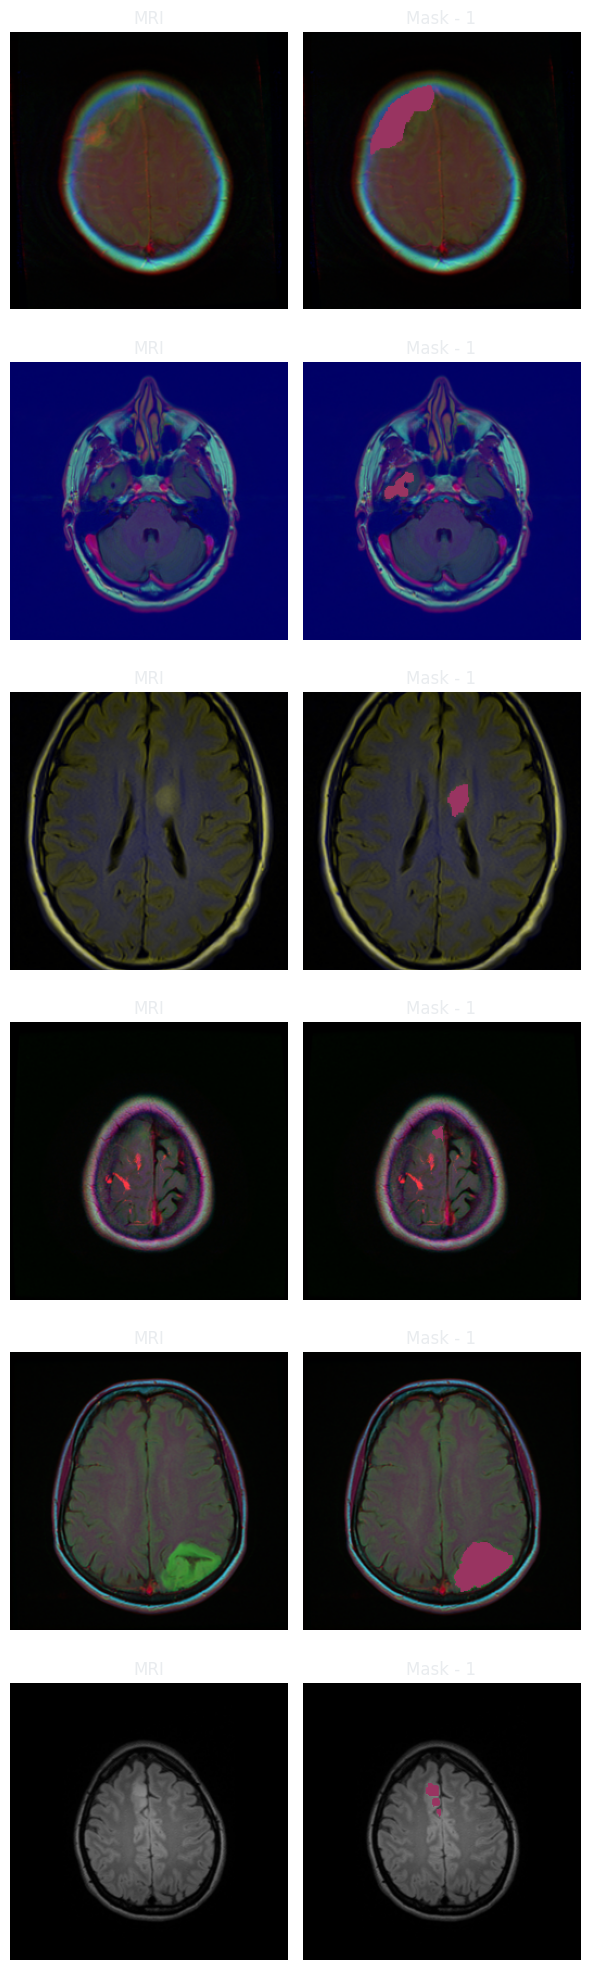

In [12]:
#HIDE
def hex_to_rgb(hex_str):
    hex_str = hex_str.lstrip("#")
    return tuple(int(hex_str[i:i+2], 16) for i in (0, 2, 4))


brain_df_mask1 = brain_df[brain_df["mask"] == 1].reset_index(drop=True)

fig, axs = plt.subplots(6, 2, figsize=(6, 20))
fig.patch.set_alpha(0)     # transparent figure bg
# ax.set_facecolor("none")   # This line was causing a NameError and is likely redundant here

count = 0 # Initialize count
for row in range(6):
  i = random.randint(0, len(brain_df_mask1))

  img = cv2.imread(brain_df_mask1.image_path[i])
  axs[row][0].set_title("MRI", color="#e9ecef") # Changed to set_title
  axs[row][0].imshow(img)
  axs[row][0].axis("off")

  axs[row][1].imshow(img)

  mask = cv2.imread(brain_df_mask1.mask_path[i],cv2.IMREAD_GRAYSCALE)

  # Overlay mask in blue with transparency
  img[mask == 255] = hex_to_rgb(palette_hex["ReLU"]) # Use a specific hex color string
  axs[row][1].imshow(img)
  axs[row][1].set_title("Mask - " + str(brain_df_mask1['mask'][i]), color="#e9ecef") # Changed to set_title
  axs[row][1].axis("off")
  count += 1

fig.tight_layout()

## Convolutional neural networks (CNNs)
- The first CNN layers are used to extract high level general features
- The last couple of layers will perform classification
- Locla respective fields scan the image first searching for simple shapes such as edges and lines
- The edges are picked up by the subsequent layer to form more complex features

A good visualisation of the feature extraction with convolutions can be found at https://setosa.io/ev/image-kernels/





## ResNet (Residual Network)
- As CNNs grow deeper, vanishing gradients negatively impact the network performance. Vanishing gradient occurs when the gradient is backpropagated to earlier layers which results in a very small gradient.
- ResNets "skip connection" feature can allow training of 152 layers without vanishing gradient problems
- ResNet adds "identity mapping on top of the CNN
- ResNet deep network is trained with ImageNet, which contains 11 million images and 11 000 categories

ResNet paper (He etal, 2015): https://arxiv.org/pdf/1512.03385

As seen in the Figure 6. from the Resnet paper, the ResNet architectures overcome the training challenges from deep networks compared ot the plain networks. ResNet-152 achieved 3.58% error rate on the ImageNet dataset. This is better than human performance.

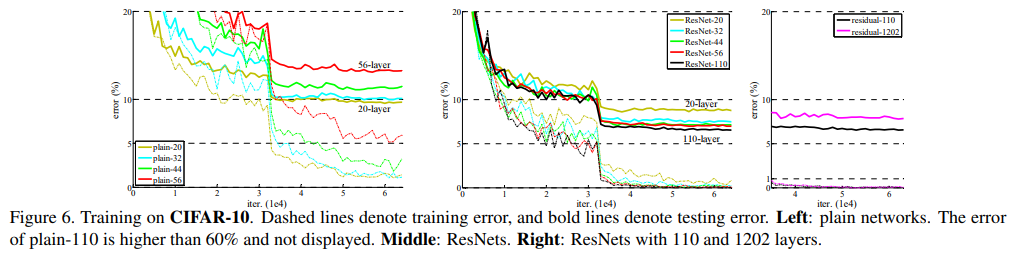

In [ ]:
#HIDE
image_path = image_base / 'resnetwork.png'
display(Image(filename=image_path))

Siddarth Das has made a great comparison of CNN architecture performances, you can check it out here: https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

## Transfer learning

Transfer learning retrains a network that has been trained to perform a specific task to use it in a similar task. The use of a pretrained model can drastically reduce the computational time and the amount of training data required, compared to starting from scratch. It can be compared to a salsa dancer starting to learn bachata; he/she will probably do a lot better than a person who has never danced before.

There are two main strategies in transfer learning:
1. **Freeze the trained CNN network weights from the first layers** and the train newly added dense layers. The new layers are initialized with random weights.
2. **Retrain the entire CNN network** while setting the learning rate to be very small. With too large learning rate the already trained weights might be changed too dramatically.

In this project I will use the approach 1.

Transfer learning has it's own challenges:
- **Negative Transfer**: the source task/domain is “close enough to look useful” but actually pushes the model in the wrong direction, hurting performance compared to training from scratch. This occurs when the features of old and new tasks are not related.
- **Which layers to transfer / freeze**: deciding what to reuse vs retrain is nontrivial; freezing too much can underfit, unfreezing too much can overfit or destabilize training.
- **Representation misalignment**: even if tasks are related, the internal features might not separate target classes well, especially when target cues differ (e.g., medical imaging vs natural images).
- **Transfer bounds**: Measuring the amount of knowledge transferred is crucial to ensure model quality and robustness. It is worth considering, how to quantify this, and it is a subject of ongoing research.


This is a great resource for transfer learning from Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a/


## ResUNet
I will use ResUNet in the second part for the segmentation of the tumors.
- ResUNet architecture combines UNet backbone architecture and residual blocks
- The Unet uses Fully Convolutional Networks (FCN) and is adapted to perform well on segmentation tasks
- ResUNet has three parts:
  1.   Encoder or contracting path
  2.   Bottleneck
  3.   Decoder or expansive path

The contraction path consists of several contraction blocks, which pass their input through res-blocks followed by 2x2 max-pooling. Feature maps after each block doubles, which helps the model learn complex features effectively.

The bottleneck part takes the input and then passes through a resblock, followed by 2x2 up-sampling convolution layers.

The decoder blocks take the up-sampled input from the previous layer and concatenates with the corresponding output features from the res-blocks in the contraction path. This is then passed through a resblock. This ensures that the features learned while contracting are used while reconstructing the image.

The final expansion layer output is passed through 1x1 convolution layer to produce the desired output with the same size as the input.

The original paper that introduced ResUNet: https://arxiv.org/pdf/1904.00592




In [ ]:
#HIDE
from IPython.display import HTML, display
from pathlib import Path

image_path = "pics/resUNet.png"   # must be inside your docs/ tree for GitHub Pages
src = str(image_path)                     # e.g. "docs/pics/resUNet.png" or "pics/resUNet.png"

display(HTML(f"""
<style>
.png-scroll {{
  max-width: 100%;
  height: 540px;
  overflow-x: auto;
  overflow-y: hidden;
  -webkit-overflow-scrolling: touch;
  border-radius: 10px;
  background: transparent;
  padding: 8px;
}}
.png-scroll img {{
  display: block;
  max-width: none !important;   /* critical: allow overflow so horizontal scroll appears */
  height: auto;                /* fit the frame height */
  width: auto;
  border: none;
}}
</style>

<div class="png-scroll">
  <img src="{src}" alt="ResUNet architecture">
</div>
"""))


# Part 1: Training a classifier model to detect if tumor exists or not

I use the flow_from_dataframe for training.
Batch size = 16
class mode = categorical

In [8]:
#HIDE
%%capture
# @title Train test split
#Drop the patient_id (we don't need it)
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.head(0)
brain_df_train.info()

#convert the data in mask column into a string format, to use categorical mode
#in flow_fom_dataframe. Otherwise we get TypeError
brain_df_train['mask'] = brain_df_train['mask'].astype(str)
brain_df_train.info()
train, test = train_test_split(brain_df_train, test_size=0.15, random_state=42)

In [7]:
#HIDE
# @title Saving the data split for classifier model
np.savez(model_base/"split_classifier_idx.npz", train_idx=train.index.to_numpy(), test_idx=test.index.to_numpy())

idx = np.load(model_base/"split_classifier_idx.npz")
train = brain_df_train.loc[idx["train_idx"]]
test  = brain_df_train.loc[idx["test_idx"]]

In [9]:
#HIDE
# @title Image generator

#create a data generator which scales the data from 0 to 1 and makes validation
#dividing with 255 normalises the values which are between 0 and 255
#split of 0.15
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)



In [10]:
# @title Preparing image generators
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size =16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)
#create a data generator for test images
#no need for splitting again because here we use the "test" data set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


Below is the architecture of the ResNet50 model. For the transfer learning, all of these layers will be set to trainable = False to stop the weights from changing. The last layers in purple are the added layers which will be trained.

In [13]:
#HIDE
# @title Helper function for plotting the architecture
!apt-get -qq install -y graphviz
!pip -q install pydot

import re
import subprocess
from pathlib import Path
from typing import Dict, Optional, Tuple, List

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG, display

def export_colored_model_graph(
    model,
    image_base,
    stem: str = "model_arch",
    palette_hex: Optional[List[str]] = None,
    type_color_map: Optional[Dict[str, str]] = None,
    show_shapes: bool = True,
    show_layer_names: bool = True,
    rankdir: str = "TB",
    size: str = "30,18",
    nodesep: str = "0.15",
    ranksep: str = "0.25",
    splines: str = "polyline",
    edge_color: str = "#000000",
    node_border_color: str = "#202020",
    bg_color: str = "white",
    border_width: int = 1,
    display_svg: bool = True,
    return_mapping: bool = True,
) -> Tuple[Path, Path, Path, Optional[Dict[str, str]]]:
    """
    Exports a Keras model graph with colored nodes (stable by layer TYPE in parentheses).
    - Stable mapping: alphabetical layer types -> palette cycle (or use type_color_map to pin types).
    - Fixes Keras HTML labels by rewriting bgcolor/font only where needed.
    - Forces consistent border color via <table color="..."> (does NOT override font colors).
    - Forces all graph edges to edge_color.
    """

    if palette_hex is None:
        palette_hex = ["#8ecae6","#219ebc","#126782","#023047","#ffb703","#fd9e02","#fb8500"]

    out_dir = Path(image_base).resolve()
    out_dir.mkdir(parents=True, exist_ok=True)

    dot_path = out_dir / f"{stem}.dot"
    svg_path = out_dir / f"{stem}.svg"
    png_path = out_dir / f"{stem}.png"

    dot = model_to_dot(
        model,
        show_shapes=show_shapes,
        show_layer_names=show_layer_names,
        rankdir=rankdir,
        expand_nested=False,
    )

    dot.set_graph_defaults(
        splines=splines,
        outputorder="edgesfirst",
        concentrate="false",
        ranksep=ranksep,
        nodesep=nodesep,
        pad="0.2",
        margin="0.2",
        ratio="compress",
        size=size,
    )

    # Node border set here is mostly irrelevant (HTML label draws the box),
    # but doesn't hurt:
    dot.set_node_defaults(fontsize="8", margin="0.02", penwidth=str(max(1, border_width)))

    # Make ALL edges black (and enforce again below on each edge)
    dot.set_edge_defaults(arrowsize="0.4", penwidth="1.1", color=edge_color)

    # ---- helpers ----
    def hex_luma(h):
        h = h.lstrip("#")
        r, g, b = int(h[0:2], 16)/255, int(h[2:4], 16)/255, int(h[4:6], 16)/255
        return 0.2126*r + 0.7152*g + 0.0722*b

    def best_text_color(fill_hex):
        return "white" if hex_luma(fill_hex) < 0.55 else "black"

    # Keras label contains: "<b>layer_name</b> (LayerType)"
    rx = re.compile(r"<b>(?P<lname>[^<]+)</b>\s*\((?P<ltype>[^)]+)\)")

    # Collect all types present
    types_found = []
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if m:
            types_found.append(m.group("ltype"))
    types_found = sorted(set(types_found))

    # Stable mapping type->color
    if type_color_map is not None:
        type_to_color = dict(type_color_map)
        remaining = [t for t in types_found if t not in type_to_color]
        for i, t in enumerate(remaining):
            type_to_color[t] = palette_hex[i % len(palette_hex)]
    else:
        type_to_color = {t: palette_hex[i % len(palette_hex)] for i, t in enumerate(types_found)}

    def _fix_table_tag(table_tag: str) -> str:
        """Ensure the <table ...> has consistent border/grid color and border widths."""
        tag = table_tag

        # Force border + cellborder to be present and consistent
        if re.search(r'\bborder="', tag):
            tag = re.sub(r'\bborder="[^"]*"', f'border="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' border="{border_width}">'

        if re.search(r'\bcellborder="', tag):
            tag = re.sub(r'\bcellborder="[^"]*"', f'cellborder="{border_width}"', tag)
        else:
            tag = tag[:-1] + f' cellborder="{border_width}">'

        # Force table border/grid color (THIS affects table lines, not text fonts)
        if re.search(r'\bcolor="', tag):
            tag = re.sub(r'\bcolor="[^"]*"', f'color="{node_border_color}"', tag)
        else:
            tag = tag[:-1] + f' color="{node_border_color}">'

        return tag

    def recolor_html_label(label: str, header_fill: str) -> str:
        """
        Rewrite Keras HTML label:
        - Replace ALL bgcolor="black" -> bgcolor=bg_color (so no leftover black fills)
        - Recolor ONLY the header cell background
        - Set ONLY the header font color for contrast
        - Force ONLY the table border/grid color (via <table color="...">)
        """
        # 1) Remove all black cell fills (Keras uses black by default)
        lab2 = label.replace('bgcolor="black"', f'bgcolor="{bg_color}"')

        # 2) Recolor header cell background (the td with colspan="2")
        lab2 = re.sub(
            r'(<td[^>]*colspan="2"[^>]*bgcolor=")([^"]*)(")',
            rf'\1{header_fill}\3',
            lab2,
            count=1
        )

        # 3) Set ONLY the header font color (first <font ... color="..."> is usually header)
        header_text = best_text_color(header_fill)
        lab2 = re.sub(
            r'(<font[^>]*color=")([^"]+)(")',
            rf'\1{header_text}\3',
            lab2,
            count=1
        )

        # 4) Force consistent table border/grid styling by editing only the <table ...> tag
        lab2 = re.sub(
            r"<table[^>]*>",
            lambda m: _fix_table_tag(m.group(0)),
            lab2,
            count=1
        )

        return lab2

    # Apply node label rewrites
    for node in dot.get_nodes():
        lab = node.get("label")
        if not lab:
            continue
        m = rx.search(lab)
        if not m:
            continue

        ltype = m.group("ltype")
        fill = type_to_color.get(ltype, palette_hex[0])

        node.set_style("filled,rounded")
        node.set_shape("box")
        node.set_color(node_border_color)  # outer node outline (if used)
        node.set_fontcolor(node_border_color)

        node.set("label", recolor_html_label(lab, fill))

    # Enforce all existing edges black as well
    for e in dot.get_edges():
        e.set_color(edge_color)

    # Write DOT
    dot_path.write_text(dot.to_string())

    # Render with cairo to avoid cropped SVG
    tmp_svg = out_dir / f"{stem}__tmp.svg"
    tmp_png = out_dir / f"{stem}__tmp.png"
    if tmp_svg.exists(): tmp_svg.unlink()
    if tmp_png.exists(): tmp_png.unlink()

    res = subprocess.run(["dot", "-Tsvg:cairo", str(dot_path), "-o", str(tmp_svg)],
                         capture_output=True, text=True)
    if res.returncode != 0:
        raise RuntimeError(f"Graphviz SVG render failed:\n{res.stderr}")

    subprocess.check_call(["dot", "-Tpng", str(dot_path), "-o", str(tmp_png)])

    tmp_svg.replace(svg_path)
    tmp_png.replace(png_path)

    if display_svg:
        svg_text = svg_path.read_text(encoding="utf-8")
        display(HTML(f"""
    <style>
    .svg-scroll {{
      max-width: 100%;
      overflow-x: auto;
      overflow-y: hidden;
      -webkit-overflow-scrolling: touch;
      touch-action: pan-x;
    }}
    .svg-scroll .inner {{
      width: max-content;          /* makes content keep its intrinsic width */
    }}
    .svg-scroll svg {{
      max-width: none !important;  /* prevents “shrink-to-fit” */
      height: auto !important;
      display: block;
    }}
    </style>

    <div class="svg-scroll">
      <div class="inner">
        {svg_text}
      </div>
    </div>
    """))
    return dot_path, svg_path, png_path, (type_to_color if return_mapping else None)



In [10]:
# @title Retrieve ResNet50 base model
#Input tensror 256 x 256 x 3
basemodel = ResNet50(weights = 'imagenet', include_top = False,
                     input_tensor = Input(shape = (256, 256, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
#HIDE
for layer in basemodel.layers:
  layers.trainable = False #set layers to a mode where they cannot be trained

In [12]:
# Add classification head to the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

fullmodel = Model(inputs = basemodel.input, outputs = headmodel)

In [13]:
#HIDE
#One can experiment with the architecture by adding more layers at the end
try_alternative_model = False
if try_alternative_model:
  headmodel = basemodel.output
  headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
  headmodel = Flatten(name= 'flatten')(headmodel)
  headmodel = Dense(256, activation = "relu")(headmodel)
  headmodel = Dropout(0.3)(headmodel)
  headmodel = Dense(256, activation = "relu")(headmodel)
  headmodel = Dropout(0.3)(headmodel)
  headmodel = Dense(2, activation = 'softmax')(headmodel)

  alt_model = Model(inputs = basemodel.input, outputs = headmodel)
#Total parameters (original model) = 25,685,634
#Total parameters (New model with added dense and dropout layers) = 25,751,426

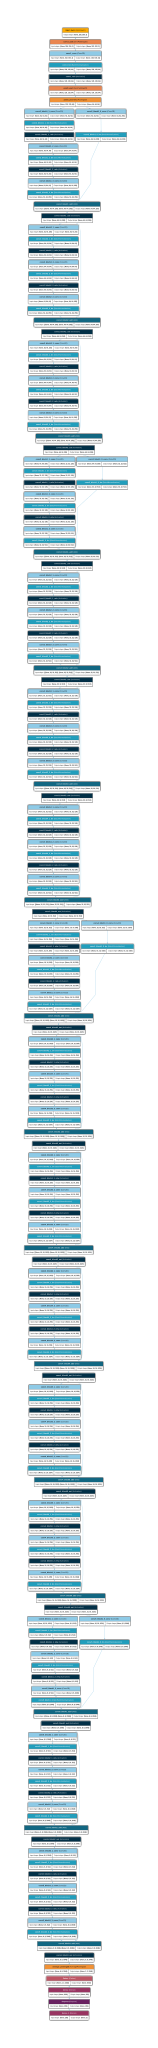

In [ ]:
#HIDE
# -----------------------------
# Full model
# -----------------------------
dot_path, svg_path, png_path, type_to_color = export_colored_model_graph(
    model=fullmodel,
    image_base=image_base,
    stem="model_arch",
    type_color_map= palette_hex,
    show_shapes=True,
    rankdir="TB",
    edge_color="#8ECAE6",
    bg_color="white",
    border_width=1,
    display_svg=True,
)


In [14]:
# compile the model
fullmodel.compile(loss = 'categorical_crossentropy', optimizer='adam',
              metrics=["accuracy"])

In [15]:
# use the early stopping to exit training
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose = 1,
                              patience = 20)
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath=model_base/'classifier-resnet-weights_22-12-2025.keras',
                               verbose=1,
                               save_best_only=True)

# Callbacks: logs epoch results to CSV
csv_logger = CSVLogger(
    model_base/"training_history_classifier_model_22-12-2025.csv",
    append=True,         # keep adding if file exists
    separator=','        # comma-separated
    )

In [16]:
#HIDE
train_model = True

In [17]:
if train_model:
  history = fullmodel.fit(train_generator,
              steps_per_epoch = train_generator.n // train_generator.batch_size,
              epochs=60,
              validation_data=valid_generator,
              validation_steps= valid_generator.n // valid_generator.batch_size,
              callbacks=[checkpointer, earlystopping,csv_logger])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6593 - loss: 1.2657
Epoch 1: val_loss improved from inf to 1.52948, saving model to /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/classifier-resnet-weights_22-12-2025.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 1071s 6s/step - accuracy: 0.6596 - loss: 1.2629 - val_accuracy: 0.3367 - val_loss: 1.5295
Epoch 2/60
  1/177 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8750 - loss: 0.2890

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.




Epoch 2: val_loss did not improve from 1.52948
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8750 - loss: 0.2890 - val_accuracy: 0.3387 - val_loss: 1.8686
Epoch 3/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7892 - loss: 0.4580
Epoch 3: val_loss improved from 1.52948 to 0.65035, saving model to /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/classifier-resnet-weights_22-12-2025.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.7893 - loss: 0.4579 - val_accuracy: 0.6593 - val_loss: 0.6504
Epoch 4/60
  1/177 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9375 - loss: 0.1734
Epoch 4: val_loss improved from 0.65035 to 0.64082, saving model to /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/classifier-resnet-weights_22-12-2025.keras
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9375 - loss: 0.1734 - val_accuracy: 0.6613 - val_loss: 0.6408
Epoch 5/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.

The best model was reached with 20 epochs, after which the training was terminated by early stopping (patience=20). Interestingly, the validation loss had one massive peak.

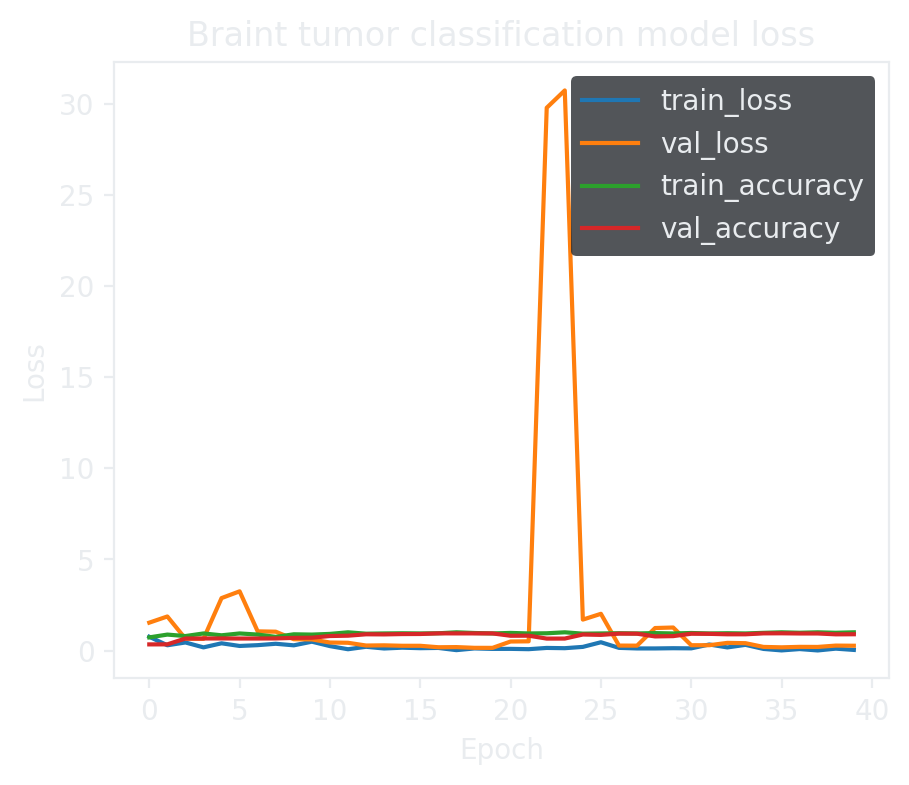

In [19]:
#HIDE
# Plot the training history

# Load data and automatically convert all numeric columns
df_his = pd.read_csv(
    model_base/'training_history_classifier_model_22-12-2025.csv',
    sep=',',
    engine='python'
).apply(pd.to_numeric, errors='coerce')

# Convert DataFrame to Keras-like history dictionary
history = df_his.to_dict(orient="list")
out_path = image_base/"classifier_model_training_history.png"

fig = plt.figure(figsize=(5,4))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Braint tumor classification model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss','train_accuracy','val_accuracy'], loc = 'upper right')

fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename=out_path, width=460))


## Assess classifier model performance


In [7]:
#HIDE
#load the trained modle
%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'
# 1) Load the saved model
model = load_model(model_base/"classifier-resnet-weights_22-12-2025.keras")

# (Optional) verify it’s really loaded
model.summary()

In [11]:
#HIDE
# 2) Use it for inference
make_predictions = True
if make_predictions:
  predictions = model.predict(test_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



37/37 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step


In [12]:

#HIDE
y_pred = []
for i in predictions:
  y_pred.append(str(np.argmax(i)))
y_pred = np.array(y_pred)
y_true = np.asarray(test['mask'])[:len(predictions)]
print('The model accuracy is {:.2f}'.format(accuracy_score(y_true, y_pred)))


The model accuracy is 0.94


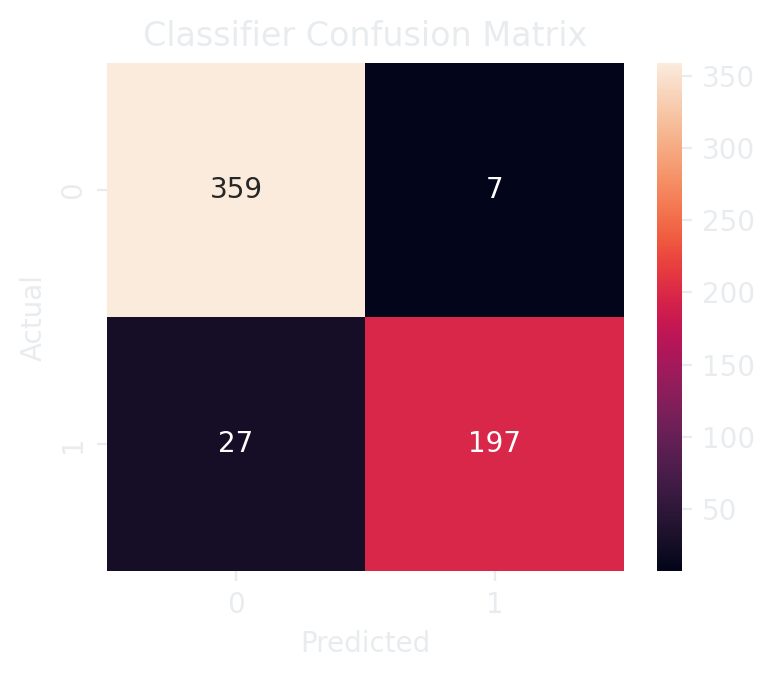

In [45]:
#HIDE
# @title Plot the confusion matrix

out_path = image_base/"classifier_cmat.png"
cmat = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(4, 3.5))
fig.patch.set_alpha(0)        # transparent figure background
ax.set_facecolor("none")      # transparent axes background

sns.heatmap(cmat, annot=True, fmt="g", ax=ax, cbar=True)

ax.set_title("Classifier Confusion Matrix", color="#e9ecef")
ax.set_xlabel("Predicted", color="#e9ecef")
ax.set_ylabel("Actual", color="#e9ecef")
ax.tick_params(colors="#e9ecef")

fig.tight_layout()

fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)
display(Image(filename=out_path, width=360))

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       366
           1       0.97      0.88      0.92       224

   micro avg       0.94      0.94      0.94       590
   macro avg       0.95      0.93      0.94       590
weighted avg       0.94      0.94      0.94       590



# Part 2: Building a segmentation model to localise tumors


In [5]:
#HIDE
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [6]:
#HIDE
# split the data into train and test data
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15,random_state=42)
X_test, X_val = train_test_split(X_val, test_size=0.5,random_state=42)

In [7]:
#HIDE
# create separate list for imageId, classId to pass into the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [8]:
#HIDE
# Save and Load the splits
if train_ids is not None:
  split_path = model_base/"segmentation_splits.json"
  splits = {
      "train_ids": train_ids,
      "train_mask": train_mask,
      "val_ids": val_ids,
      "val_mask": val_mask,
      "test_ids": test_ids,
      "test_mask": test_mask,
  }
  with split_path.open("w") as f:
      json.dump(splits, f, indent=2)

  print("Saved to:", split_path.resolve())

if train_ids is None:
  with split_path.open("r") as f:
      splits = json.load(f)
  train_ids  = splits["train_ids"]
  train_mask = splits["train_mask"]
  val_ids    = splits["val_ids"]
  val_mask   = splits["val_mask"]
  test_ids   = splits["test_ids"]
  test_mask  = splits["test_mask"]


Saved to: /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/segmentation_splits.json


In [9]:
#HIDE
# @title Create image generators
from utilities import DataGenerator
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [10]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [11]:
# function to upscale and concatenate the values passed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [12]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
#HIDE
model_seg.summary()

In [13]:

# @title Compiling the segmentation model
from utilities import tversky, tversky_loss, focal_tversky
adam = keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [14]:
#HIDE
# @title Callbacks and training
retrain_model = True
if retrain_model:
  # Early stopping:
  # exit training if validation loss is not decreasing even after certain epochs (patience)
  earlystopping = EarlyStopping(monitor='val_loss',
                                mode='min',
                                verbose=1,
                                patience=20)

  # save the best model with lower validation loss
  checkpointer = ModelCheckpoint(filepath=model_base/"ResUNet-weights_22-12-2025.keras",
                                verbose=1,
                                save_best_only=True)

  # Callbacks: logs epoch results to CSV
  csv_logger = CSVLogger(
        model_base/"training_history_segmodel_22-12-2025.csv",
        append=True,         # keep adding if file exists
        separator=','        # comma-separated
    )

  # fit with CSVLogger included
  history = model_seg.fit(
    training_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[checkpointer, earlystopping, csv_logger],
  )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.8267 - tversky: 0.2203

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.




Epoch 1: val_loss improved from inf to 0.59689, saving model to /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/ResUNet-weights_22-12-2025.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 760s 10s/step - loss: 0.8249 - tversky: 0.2224 - val_loss: 0.5969 - val_tversky: 0.4970
Epoch 2/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.4331 - tversky: 0.6690
Epoch 2: val_loss did not improve from 0.59689
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - loss: 0.4330 - tversky: 0.6691 - val_loss: 0.6728 - val_tversky: 0.4079
Epoch 3/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3882 - tversky: 0.7145
Epoch 3: val_loss improved from 0.59689 to 0.36208, saving model to /content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Models/ResUNet-weights_22-12-2025.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - loss: 0.3879 - tversky: 0.7147 - val_loss: 0.3621 - val_tversky: 0.7410
Epoch 4/60
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.3287 - tversky: 0.7716
Epoch 4: val_loss 

The best model was reached on epoch 36. After that the validation loss did not improve and early stopping rule was reached (patience=20).

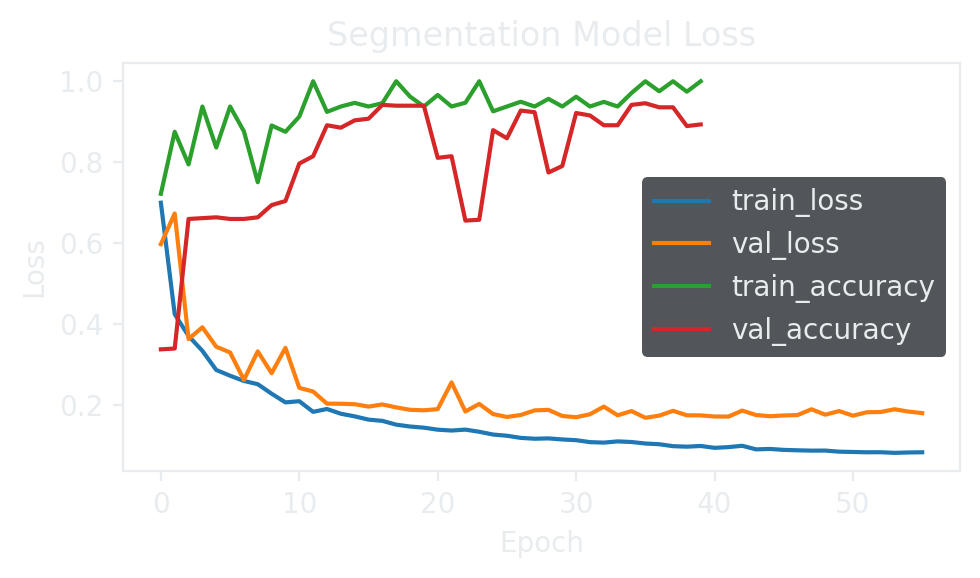

In [25]:
if not retrain_model:
    df_his = pd.read_csv(model_base/"training_history_segmodel_22-12-2025.csv", sep=None, engine="python")
    df_his = df_his.apply(pd.to_numeric, errors="coerce")
    history_data = df_his.to_dict(orient="list")
else:
    history_data = history.history  # Keras History object

# ---- plot ----

out_path = image_base/"seg_model_train_history.png"

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(history_data["loss"], label="train_loss")
ax.plot(history_data["val_loss"], label="val_loss")

ax.set_title("Segmentation Model Loss")
ax.set_ylabel("Loss")

ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set_xlabel("Epoch")
ax.legend(['train_loss','val_loss','train_accuracy','val_accuracy'], loc="center right")

fig.tight_layout()
fig.savefig(out_path, dpi=200, bbox_inches="tight", transparent=True)
plt.close(fig)

display(Image(filename=out_path,width=460))

In [ ]:
#HIDE
#load the trained modle
%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'
# 1) Load the saved model
# Define custom_objects dictionary to pass custom functions
custom_objects = {
    'focal_tversky_fixed': focal_tversky_fixed,
    'tversky_fixed': tversky_fixed
}
model_seg = load_model("ResUNet-weights.keras", custom_objects=custom_objects)

# (Optional) verify it’s really loaded
model_seg.summary()

## Assessing the trained segmentation model performance

To assess the performance, the predicted and actual masks of 10 test cases are printed below. The model has not seen this data before.

In [39]:
#HIDE
# @title Make predictions with both models
image_id, mask, has_mask = prediction(X_test, model, model_seg)
# Extract image and mask paths for the segmentation test set from X_test



In [29]:
#HIDE
# @title Create a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
#df_pred.head()

In [30]:
#HIDE
#Merge the dataframe containing predicted results with the original test data
df_pred = test.merge(df_pred, on = 'image_path')
#df_pred.head()

In [31]:
#HIDE
%%capture
#saving and reloading

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/Brain_MRI'
# save
df_pred.to_pickle("df_pred_with_predictions.pkl")

# load later
df_pred = pd.read_pickle("df_pred_with_predictions.pkl")


In [32]:
#HIDE
count = 0
fig, axs = plt.subplots(10, 5, figsize=(10, 20))
fig.patch.set_alpha(0)

for i in range(len(df_pred)):
  # Check if the 'mask' column from the original dataframe indicates a tumor (string '1')
  # and if we haven't plotted 10 examples with masks yet.
  if str(df_pred['has_mask'].iloc[i]) == '1' and count < 10:
    # Read the MRI image and convert it to RGB format
    img_mri = cv2.imread(df_pred.image_path.iloc[i])
    img_mri = cv2.cvtColor(img_mri, cv2.COLOR_BGR2RGB)
    axs[count][0].set_title("Brain MRI", color="#e9ecef")
    axs[count][0].imshow(img_mri)
    axs[count][0].axis("off")

    # Obtain the original mask for the image, ensuring it's read as grayscale
    mask_original = cv2.imread(df_pred.mask_path.iloc[i], cv2.IMREAD_GRAYSCALE)
    axs[count][1].set_title("Original Mask", color="#e9ecef")
    axs[count][1].imshow(mask_original, cmap="gray") # Display grayscale mask with gray colormap
    axs[count][1].axis("off")

    # Obtain the predicted mask for the image
    # It's stored as an array in 'predicted_mask_array'
    predicted_mask_raw = df_pred.predicted_mask.iloc[i]
    # Ensure the predicted mask is 2D (height, width) for imshow and binarize
    predicted_mask = predicted_mask_raw.reshape(256, 256).round().astype(np.uint8)

    axs[count][2].set_title("AI Predicted Mask", color="#e9ecef")
    axs[count][2].imshow(predicted_mask, cmap="gray") # Display grayscale predicted mask
    axs[count][2].axis("off")

    # Create an overlay of the original mask on the MRI image
    # Use a fresh copy of the MRI image to avoid affecting subsequent plots
    img_overlay_original = img_mri.copy()
    # Apply the original mask in red color (255, 0, 0)
    img_overlay_original[mask_original == 255] = (255, 0, 0)
    axs[count][3].set_title("MRI & Original Mask", color="#e9ecef")
    axs[count][3].imshow(img_overlay_original)
    axs[count][3].axis("off")

    # Create an overlay of the AI predicted mask on the MRI image
    img_overlay_predicted = img_mri.copy()
    # Apply the predicted mask in green color (0, 255, 0)
    img_overlay_predicted[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].set_title("MRI & AI Predicted Mask", color="#e9ecef")
    axs[count][4].imshow(img_overlay_predicted)
    axs[count][4].axis("off")

    count += 1

# Adjust layout to prevent titles/labels from overlapping
fig.tight_layout()

# ✅ robust for nbconvert HTML: write an actual PNG file
out_path = "/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector/docs/pics/segmentation_grid.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight", transparent=True)
plt.close(fig)


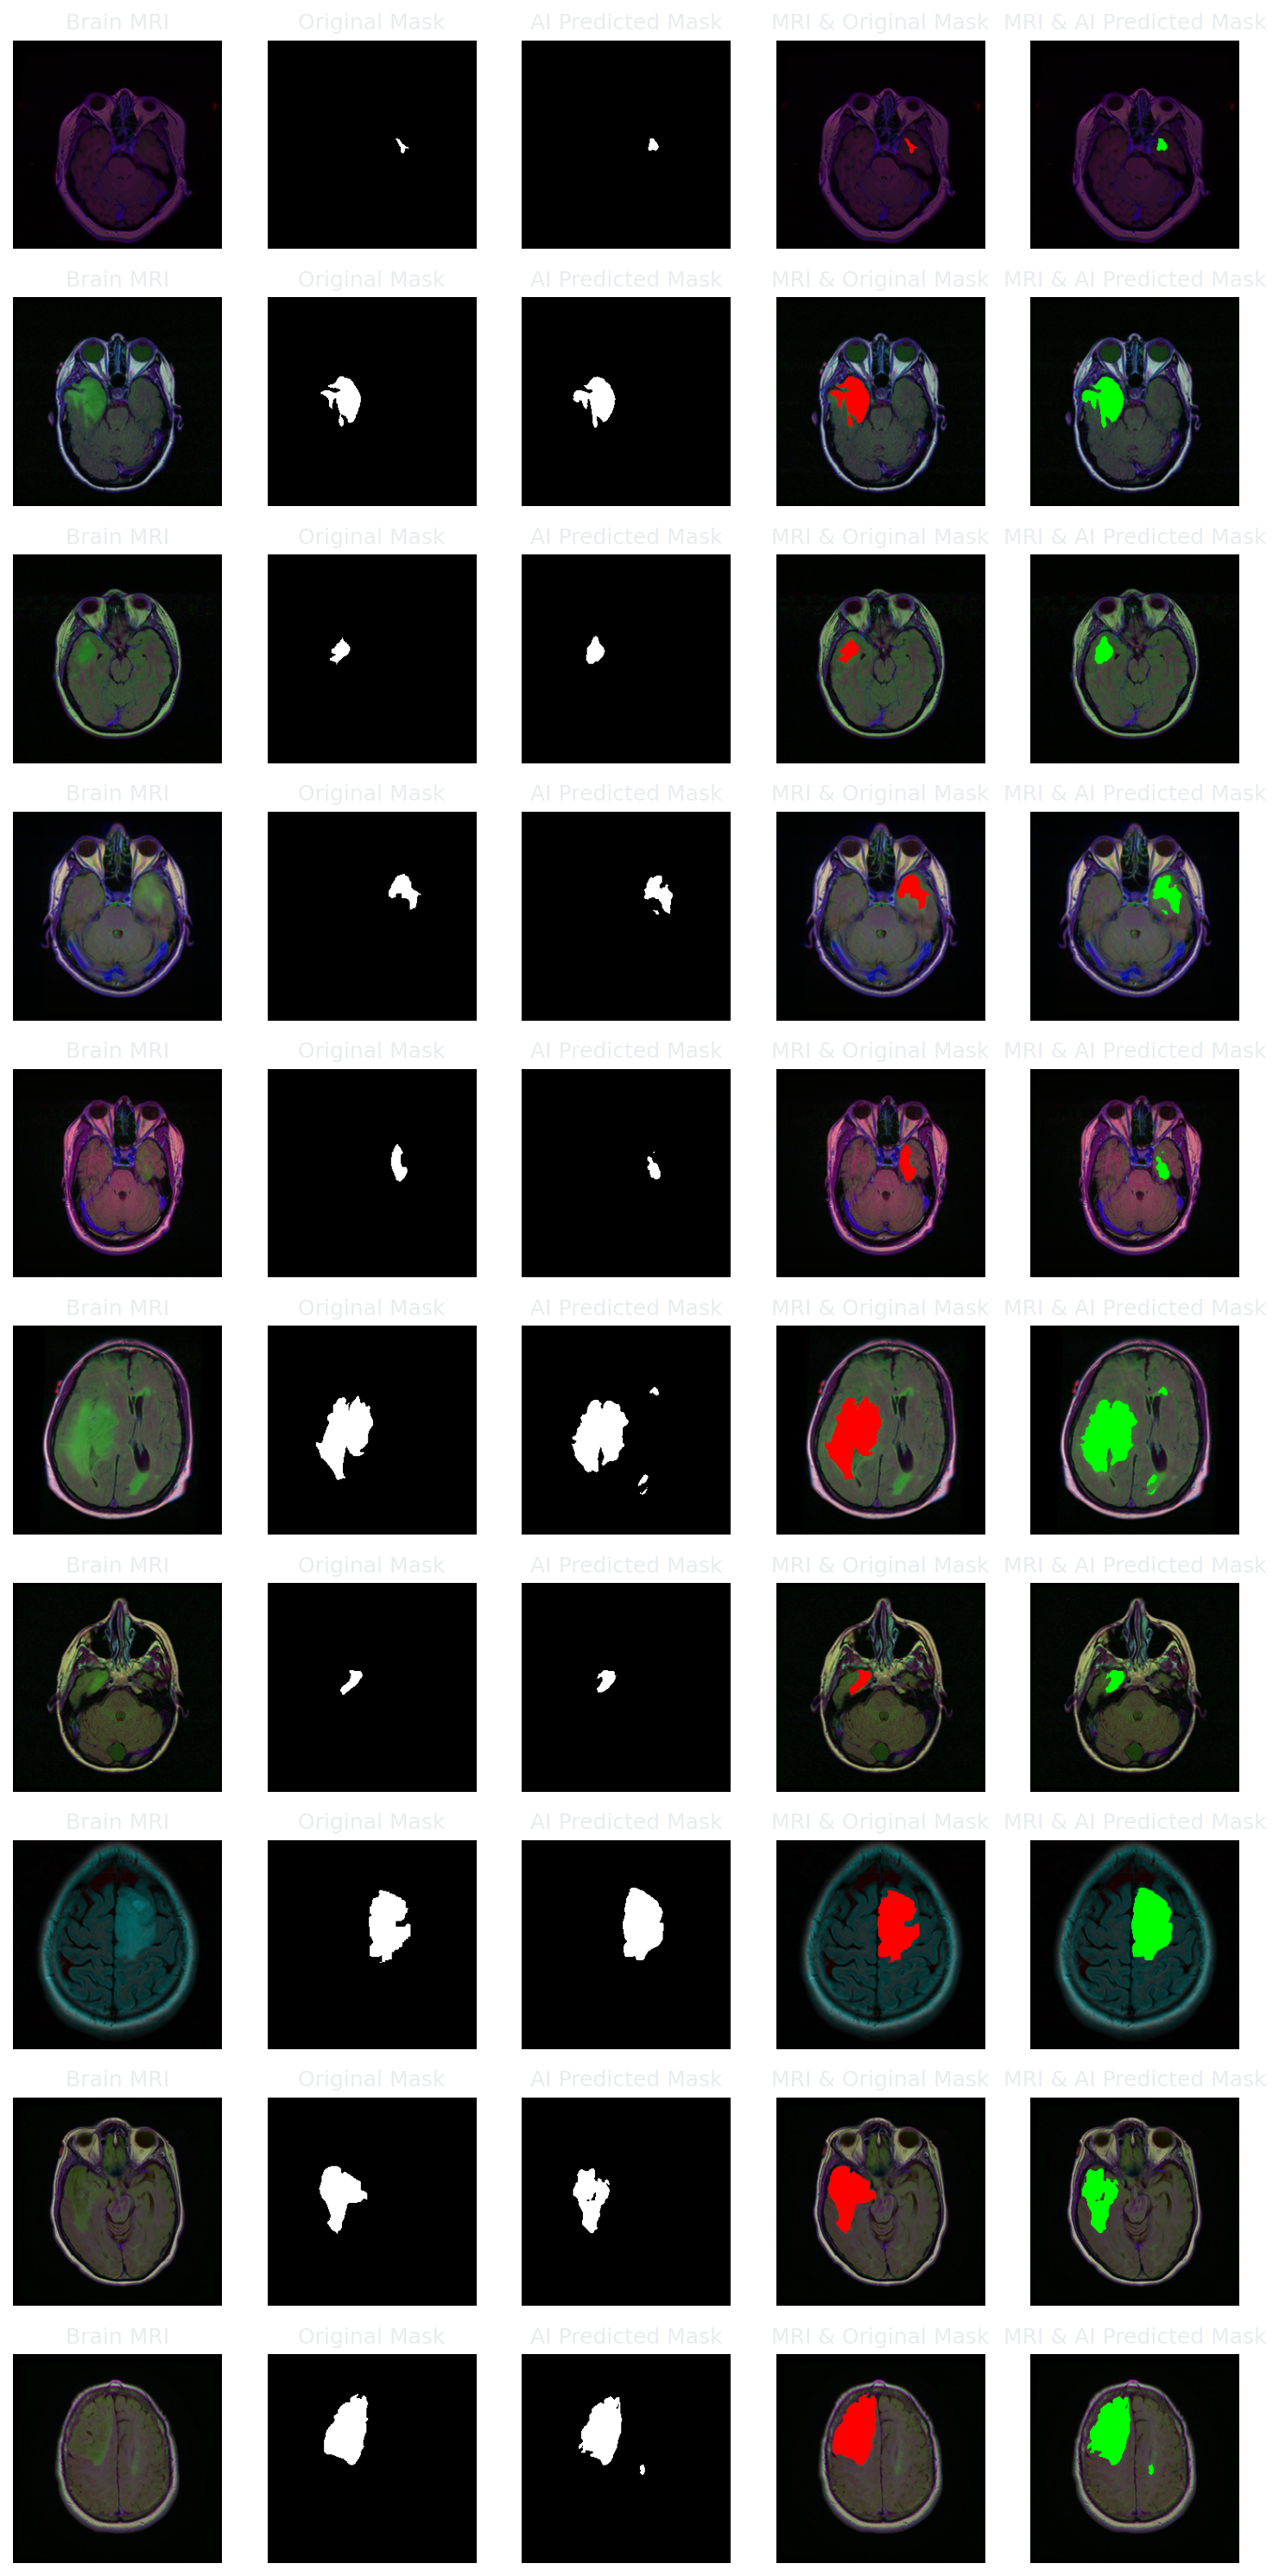

In [33]:
#HIDE
image_path = image_base / 'segmentation_grid.png'
display(Image(filename = image_path,width=950))

In [42]:
#HIDE
%%capture
push_git = True
# @title GIT commands
# Add changes
if push_git:
  !git add .

In [ ]:
#HIDE
!git status -sb
!git add .gitignore

In [43]:
#HIDE
%%capture
# Commit changes and remember to change commit message
if push_git:
  !git commit -m "Setting up the correct fontcolors" #Remember to change commit message

In [44]:
#HIDE
%%capture
# Push changes
if push_git:
  with open('/content/drive/MyDrive/tokens/token1.txt', 'r') as f:
      token = f.read().strip()

  !git push https://$token@github.com/KaisuH/brain-tumor-detector.git

In [ ]:
#HIDE
#for removing the last line in gitignore
#!sed -i '$d' .gitignore
#for printing the gitignore
#!cat .gitignore

In [ ]:
#HIDE
make_new_branch = False
if make_new_branch:
  # 1. Create a brand-new “orphan” branch (no history)
  !git checkout --orphan clean-start

  # 2. Stage everything in your current working directory
  !git add -A

  # 3. Commit it as your one “fresh start” commit
  !git commit -m "Fresh start: keep only current work"

  # 4. Force-push this new branch to overwrite remote main
  !git push https://$token@github.com/KaisuH/Emotion-AI.git clean-start:main --force

  # 5. (Optional) Switch back to ‘main’ locally and delete the temp branch
  !git checkout main
  !git branch -D clean-start

In [39]:
#HIDE
# @title Producing the final file
%%capture

%cd '/content/drive/MyDrive/Colab Notebooks/brain-tumor-detector'
import nbformat

nb_name = "master.ipynb"        # original notebook
out_nb_name = "master_tagged.ipynb"  # new notebook with tags

nb = nbformat.read(nb_name, as_version=4)

for cell in nb.cells:
    if cell.cell_type == 'code':
        # Check if the first line of the cell source is #HIDE
        first_line = cell.source.strip().split('\n',1)[0]
        if first_line.strip().startswith('#HIDE'):
            cell.metadata.setdefault('tags', []).append('hide_input')
nbformat.write(nb, out_nb_name)

In [40]:
#HIDE
%%capture
#Run this code to generate the tagged file
%%writefile hide_code_config.json
{
  "TagRemovePreprocessor": {
    "enabled": true,
    "remove_input_tags": ["hide_input"]
  },
  "Exporter": {
    "exclude_input_prompt": true,
    "exclude_output_prompt": true
  }
}

In [41]:
#HIDE
%%capture
# 1) Convert notebook -> docs/index.html
!jupyter nbconvert --to html --config hide_code_config.json \
    --output "docs/index.html" "master_tagged.ipynb"

import re
from pathlib import Path

# -----------------------------
# Settings
# -----------------------------
TITLE = "Brain tumor detector"

docs_dir = Path("docs")
html_path = docs_dir / "index.html"

# Assets are NOW in docs/ (same folder as index.html)
bootstrap_file = docs_dir / "bootstrap.min.css"
navbar_file    = docs_dir / "navbar.html"

bootstrap_href = "bootstrap.min.css"  # relative to docs/index.html

# -----------------------------
# Sanity checks
# -----------------------------
if not html_path.exists():
    raise FileNotFoundError("docs/index.html not found (nbconvert failed?)")
if not bootstrap_file.exists():
    raise FileNotFoundError("docs/bootstrap.min.css not found")
if not navbar_file.exists():
    raise FileNotFoundError("docs/navbar.html not found")

# -----------------------------
# Read generated HTML
# -----------------------------
html = html_path.read_text(encoding="utf-8")

def remove_block(text: str, start_marker: str, end_marker: str) -> str:
    return re.sub(re.escape(start_marker) + r".*?" + re.escape(end_marker),
                  "", text, flags=re.DOTALL)

# -----------------------------
# Title (robust)
# -----------------------------
html = re.sub(r"<title>.*?</title>", f"<title>{TITLE}</title>", html, count=1,
              flags=re.IGNORECASE | re.DOTALL)

# -----------------------------
# Bootstrap CSS link (idempotent)
# -----------------------------
BOOT_START = "<!-- BOOTSTRAP LINK START -->"
BOOT_END   = "<!-- BOOTSTRAP LINK END -->"
html = remove_block(html, BOOT_START, BOOT_END)

bootstrap_link_block = f"""{BOOT_START}
<link rel="stylesheet" href="{bootstrap_href}">
{BOOT_END}
"""
html = re.sub(r"</head>", bootstrap_link_block + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Navbar injection:
# - put ALL <style>...</style> from navbar.html into <head>
# - put ONLY <nav>...</nav> into <body>
# -----------------------------
navbar_raw = navbar_file.read_text(encoding="utf-8")

NAVSTYLE_START = "<!-- NAVBAR STYLES START -->"
NAVSTYLE_END   = "<!-- NAVBAR STYLES END -->"
NAV_START      = "<!-- NAVBAR START -->"
NAV_END        = "<!-- NAVBAR END -->"

html = remove_block(html, NAVSTYLE_START, NAVSTYLE_END)
html = remove_block(html, NAV_START, NAV_END)

# Extract styles
navbar_styles = "\n".join(
    re.findall(r"<style[\s\S]*?</style>", navbar_raw, flags=re.IGNORECASE)
).strip()

if navbar_styles:
    html = re.sub(
        r"</head>",
        f"{NAVSTYLE_START}\n{navbar_styles}\n{NAVSTYLE_END}\n</head>",
        html,
        count=1,
        flags=re.IGNORECASE
    )

# Extract nav
nav_match = re.search(r"<nav[\s\S]*?</nav>", navbar_raw, flags=re.IGNORECASE)
if not nav_match:
    raise ValueError("Could not find a <nav>...</nav> block inside docs/navbar.html")

navbar_nav = nav_match.group(0).strip()

# Insert navbar right after opening <body ...>
html = re.sub(
    r"(<body[^>]*>)",
    r"\1\n" + f"{NAV_START}\n{navbar_nav}\n{NAV_END}\n",
    html,
    count=1,
    flags=re.IGNORECASE
)

# -----------------------------
# CONTENT COLUMN WRAPPER (idempotent)
# This centers ONLY the notebook content AFTER the navbar.
# -----------------------------
COL_START = "<!-- CONTENT COLUMN START -->"
COL_END   = "<!-- CONTENT COLUMN END -->"
html = remove_block(html, COL_START, COL_END)

# Start wrapper right after NAV_END
if NAV_END in html:
    html = html.replace(
        NAV_END,
        NAV_END + f"\n{COL_START}\n<div class=\"content-column\">\n",
        1
    )

# Close wrapper right before </body> (so navbar is NOT inside the column)
html = re.sub(
    r"</body>",
    f"\n</div>\n{COL_END}\n</body>",
    html,
    count=1,
    flags=re.IGNORECASE
)

# -----------------------------
# Table of contents (idempotent)
# -----------------------------
TOC_START = "<!-- TOC START -->"
TOC_END   = "<!-- TOC END -->"
html = remove_block(html, TOC_START, TOC_END)

toc_block = f"""{TOC_START}
<details class="page-toc" open>
  <summary>Contents</summary>
  <nav id="page-toc"></nav>
</details>

<script>
document.addEventListener('DOMContentLoaded', function () {{
  const root = document.querySelector('.content-column') || document.body;
  const toc  = document.getElementById('page-toc');
  if (!toc) return;

  const headings = root.querySelectorAll('h1, h2, h3');
  const slug = (s) => s.toLowerCase().trim()
    .replace(/[^a-z0-9\\s-]/g, '')
    .replace(/\\s+/g, '-');

  const used = new Set();
  headings.forEach((h, i) => {{
    if (h.closest('.page-toc')) return;

    let id = h.id || slug(h.textContent) || ('section-' + i);
    while (used.has(id)) id = id + '-' + i;
    used.add(id);
    h.id = id;

    const a = document.createElement('a');
    a.href = '#' + id;
    a.textContent = h.textContent;
    a.className = 'toc-' + h.tagName.toLowerCase();
    toc.appendChild(a);
  }});
}});
</script>
{TOC_END}
"""

html = html.replace('<div class="content-column">', '<div class="content-column">\n' + toc_block, 1)

# -----------------------------
# Dark background + scroll fix (idempotent)
# -----------------------------
DARK_START = "<!-- DARK OVERRIDES START -->"
DARK_END   = "<!-- DARK OVERRIDES END -->"
html = remove_block(html, DARK_START, DARK_END)

dark_css = f"""{DARK_START}
<style>
html, body {{
  background: linear-gradient(360deg, #3a3f44, #272b30, #1b1f24) !important;
  background-attachment: fixed !important;
  margin: 0 !important;
  padding: 0 !important;
  color: #aaa !important;
}}

/*CENTER COLUMN (affects only what we wrapped) */
.content-column {{
  max-width: 1140px !important;
  margin: 40px auto 0 auto !important;
  padding-left: 15px !important;
  padding-right: 15px !important;
}}

#notebook-container,
.container, .container-fluid,
.jp-Notebook, .jp-NotebookPanel, .jp-NotebookPanel-notebook,
.jp-Cell, .jp-Cell-inputWrapper, .jp-Cell-outputWrapper,
.jp-OutputArea, .jp-OutputArea-output,
.jp-RenderedHTMLCommon, .jp-RenderedText {{
  background: transparent !important;
  color: inherit !important;
}}


/*Make *output* code/text green (prints, tracebacks, etc.) */
.jp-OutputArea pre,
.jp-OutputArea-output pre,
.jp-OutputArea-output,
.jp-OutputArea-output code,
.output pre,
.output code {{color: #66ff66 !important;
}}

 /*Mauve hyperlinks everywhere EXCEPT inside the navbar */
a, a:link, a:visited {{
  color: #993461 !important;
}}
a:hover, a:focus, a:active {{
  color: #993461 !important;
  text-decoration: underline;
}}

/* Don't override navbar link colors */
nav a, .navbar a {{
  color: inherit !important;
  text-decoration: none !important;
}}

.jp-RenderedText pre,
.jp-RenderedHTMLCommon pre,
.jp-Cell .jp-Cell-inputWrapper .CodeMirror-lines,
.jp-Cell .jp-Cell-inputWrapper pre,
pre {{
  white-space: pre !important;
  overflow-x: auto !important;
  max-width: 100% !important;
  display: block !important;
}}

/*TOC styles */
.page-toc {{
  margin: 10px 0 20px 0;
  padding: 10px 12px;
  border-radius: 10px;
  background: rgba(0,0,0,0.18);
}}
.page-toc summary {{
  cursor: pointer;
  color: #e9ecef;
  font-weight: 600;
}}
.page-toc nav a {{
  display: block;
  color: #e9ecef;
  text-decoration: none;
  padding: 2px 0;
}}
.page-toc nav a:hover {{ text-decoration: underline; }}
.page-toc nav a.toc-h2 {{ padding-left: 14px; opacity: 0.95; }}
.page-toc nav a.toc-h3 {{ padding-left: 28px; opacity: 0.9; }}

</style>
{DARK_END}
"""
html = re.sub(r"</head>", dark_css + "\n</head>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Bootstrap JS for navbar toggler (idempotent)
# -----------------------------
JS_START = "<!-- BOOTSTRAP NAVBAR JS START -->"
JS_END   = "<!-- BOOTSTRAP NAVBAR JS END -->"
html = remove_block(html, JS_START, JS_END)

bootstrap_js = f"""{JS_START}
<script src="https://code.jquery.com/jquery-3.5.1.slim.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/popper.js@1.16.1/dist/umd/popper.min.js"></script>
<script src="https://cdn.jsdelivr.net/npm/bootstrap@4.5.2/dist/js/bootstrap.min.js"></script>
{JS_END}
"""
html = re.sub(r"</body>", bootstrap_js + "\n</body>", html, count=1, flags=re.IGNORECASE)

# -----------------------------
# Save
# -----------------------------
html_path.write_text(html, encoding="utf-8")
